Prepare csvs for content review

In [1]:
import torch
import pandas as pd
import os.path
from sentence_transformers import SentenceTransformer, util
from os.path import join
item_gen_path = "/home/aml7990/Code/creativity-item-generation/outputs/without_eval_scores/with_controversial_filter_few_shot"

/home/aml7990/miniconda3/envs/AIG/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
dirs = [
    d
    for d in os.listdir(item_gen_path)
    if os.path.isdir(os.path.join(item_gen_path, d))
]
all_items_round_0 = []
all_items_round_4 = []
for d in dirs:
    # skip over runs that are still processing:
    print(d)
    files = os.listdir(join(item_gen_path, d))
    if "config.json" not in files or "items.json" not in files or "item_responses_round_0.json" not in files or "item_responses_round_4.json" not in files:
        continue
    items = pd.read_json(join(item_gen_path, d, "items.json"))
    if len(items) == 0:
        continue

    print(d)
    items_round_0 = items[
        ["creative_scenario_round_0", "word_list", "item_gen_model_name"]
    ]
    items_round_4 = items[
        ["creative_scenario_round_4", "word_list", "item_gen_model_name"]
    ]
    items_round_0["embedding"] = items_round_0["creative_scenario_round_0"].apply(lambda x: model.encode(x))
    items_round_4["embedding"] = items_round_4["creative_scenario_round_4"].apply(lambda x: model.encode(x))
    config = pd.read_json(join(item_gen_path, d, "config.json"), orient="index").T
    combined_round_0 = items_round_0.merge(
        config, how="outer", left_on="item_gen_model_name", right_on="itemGenModelName"
    )
    combined_round_4 = items_round_4.merge(
        config, how="outer", left_on="item_gen_model_name", right_on="itemGenModelName"
    )
    all_items_round_0.append(combined_round_0)
    all_items_round_4.append(combined_round_4)

all_items_round_0 = pd.concat(all_items_round_0).reset_index(drop=True)
all_items_round_4 = pd.concat(all_items_round_4).reset_index(drop=True)

In [9]:
print(len(all_items_round_0))
print(len(all_items_round_4))

401
401


In [10]:
# remove items that are too similar to already existing items
while True:
    drop = False
    print(len(all_items_round_0))
    for index, row in all_items_round_0.iterrows():
        others = all_items_round_0.loc[all_items_round_0.index != index]
        sims = util.cos_sim(row["embedding"],others["embedding"].to_list())[0]
        if len(sims[sims >= 0.95]):
            drop = True
            break
    
    if not drop or len(all_items_round_0) == 0:
        break
    else:
        all_items_round_0 = all_items_round_0.loc[all_items_round_0.index != index].reset_index(drop=True)
        

401
400
399


/home/aml7990/miniconda3/envs/AIG/lib/python3.11/site-packages/sentence_transformers/util.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400430266/work/torch/csrc/utils/tensor_new.cpp:261.)
  b = torch.tensor(b)


398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299


In [11]:
# remove items that are too similar to already existing items
while True:
    drop = False
    print(len(all_items_round_4))
    for index, row in all_items_round_4.iterrows():
        others = all_items_round_4.loc[all_items_round_4.index != index]
        sims = util.cos_sim(row["embedding"],others["embedding"].to_list())[0]
        if len(sims[sims >= 0.95]):
            drop = True
            break
    
    if not drop or len(all_items_round_4) == 0:
        break
    else:
        all_items_round_4 = all_items_round_4.loc[all_items_round_4.index != index].reset_index(drop=True)

401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224


In [12]:
all_items_round_0.drop(columns="embedding",inplace=True)
all_items_round_4.drop(columns="embedding",inplace=True)

In [13]:
all_items_round_4.to_csv("last_generated_items.csv")
all_items_round_0.to_csv("first_generated_items.csv")

## Compute Results for Content Review

In [60]:
import seaborn as sns
import pandas as pd

ratings_round_4 = pd.read_csv("/home/aml7990/Code/creativity-item-generation/Content Review/AllItemsToScore_rated.csv")
ratings_round_4["RoundOfGeneration"] = ratings_round_4["RoundOfGeneration"].apply(lambda x: 5 if x == 2 else 1)
ratings_round_4.columns

Index(['Idoriginal', 'Idnew', 'RoundOfGeneration', 'creative_scenario_round_4',
       'word_list', 'item_gen_model_name', 'random_seed', 'numIter',
       'itemGenModelName', 'useItemEvalModel', 'useItemResponseEvalModel',
       'itemEvalModelName', 'itemResponseGenModelName',
       'itemGenFrequencyPenalty', 'itemEvalFrequencyPenalty',
       'itemResponseGenFrequencyPenalty', 'itemGenPresencePenalty',
       'itemEvalPresencePenalty', 'itemResponseGenPresencePenalty',
       'itemGenTemperature', 'itemEvalTemperature',
       'itemResponseGenTemperature', 'itemGenTopP', 'itemEvalTopP',
       'itemResponseGenTopP', 'itemGenPromptIdx', 'itemEvalPromptIdx',
       'itemResponseGenPromptIdx', 'itemGenMaxTokens', 'itemEvalMaxTokens',
       'itemResponseGenMaxTokens', 'wordlistFile', 'demographicsFile',
       'itemGenOutputFile', 'itemEvalOutputFile', 'itemResponseGenOutputFile',
       'numItemsPerList', 'numItemGenerationAttempts',
       'itemResponseOriginalityModelDir', 'itemRes

In [ ]:
# inter rater agreement
from pyirr.kripp_alpha import kripp_alpha
from pyirr import kappam_fleiss
# rater 3 is problematic
ratings_no_3 = ratings_round_4[["Complexity_rater5","Complexity_rater1",]].fillna(-1).to_numpy()
# including all raters
ratings = ratings_round_4[["Complexity_rater5","Complexity_rater3","Complexity_rater1"]].fillna(-1).to_numpy()
# kripp_alpha(ratings=ratings,method="ordinal")
print("Not including rater 3:")
print(kappam_fleiss(ratings_no_3))

print("Including rater 3:")
kappam_fleiss(ratings)

In [69]:
len(ratings_round_4.loc[ratings_round_4["RoundOfGeneration"] == 5][(ratings_round_4["Controversial_rater1"] == 1) | (ratings_round_4["Controversial_rater5"] == 1) | (ratings_round_4["Controversial_rater2"] == 1) | (ratings_round_4["Controversial_rater4"] == 1)])

/tmp/ipykernel_504007/1945134157.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(ratings_round_4.loc[ratings_round_4["RoundOfGeneration"] == 5][(ratings_round_4["Controversial_rater1"] == 1) | (ratings_round_4["Controversial_rater5"] == 1) | (ratings_round_4["Controversial_rater2"] == 1) | (ratings_round_4["Controversial_rater4"] == 1)])


14

In [68]:
len(ratings_round_4.loc[ratings_round_4["RoundOfGeneration"] == 1][(ratings_round_4["Controversial_rater1"] == 1) | (ratings_round_4["Controversial_rater5"] == 1) | (ratings_round_4["Controversial_rater2"] == 1) | (ratings_round_4["Controversial_rater4"] == 1)])

/tmp/ipykernel_504007/2600968393.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(ratings_round_4.loc[ratings_round_4["RoundOfGeneration"] == 1][(ratings_round_4["Controversial_rater1"] == 1) | (ratings_round_4["Controversial_rater5"] == 1) | (ratings_round_4["Controversial_rater2"] == 1) | (ratings_round_4["Controversial_rater4"] == 1)])


17

In [71]:
len(ratings_round_4.loc[ratings_round_4["RoundOfGeneration"] == 5][(ratings_round_4["Accessibility_rater1"] == 1) | (ratings_round_4["Accessibility_rater5"] == 1) | (ratings_round_4["Accessibility_rater2"] == 1) | (ratings_round_4["Accessibility_rater4"] == 1)])

/tmp/ipykernel_504007/1034743489.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(ratings_round_4.loc[ratings_round_4["RoundOfGeneration"] == 5][(ratings_round_4["Accessibility_rater1"] == 1) | (ratings_round_4["Accessibility_rater5"] == 1) | (ratings_round_4["Accessibility_rater2"] == 1) | (ratings_round_4["Accessibility_rater4"] == 1)])


2

In [72]:
len(ratings_round_4.loc[ratings_round_4["RoundOfGeneration"] == 1][(ratings_round_4["Accessibility_rater1"] == 1) | (ratings_round_4["Accessibility_rater5"] == 1) | (ratings_round_4["Accessibility_rater2"] == 1) | (ratings_round_4["Accessibility_rater4"] == 1)])

/tmp/ipykernel_504007/3971453942.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(ratings_round_4.loc[ratings_round_4["RoundOfGeneration"] == 1][(ratings_round_4["Accessibility_rater1"] == 1) | (ratings_round_4["Accessibility_rater5"] == 1) | (ratings_round_4["Accessibility_rater2"] == 1) | (ratings_round_4["Accessibility_rater4"] == 1)])


2

/tmp/ipykernel_504007/820750830.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_complexity["mean_complexity"] = melted_complexity[["Complexity_rater5","Complexity_rater1","Complexity_rater4","Complexity_rater2"]].mean(axis=1,numeric_only=True)


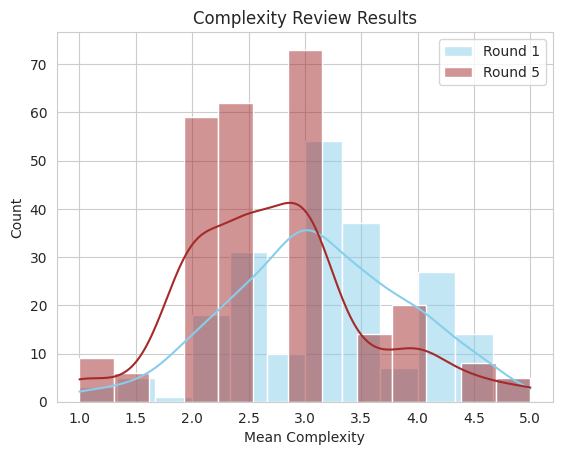

In [73]:
# graphs of annotator distributions
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# melted_complexity = pd.melt(ratings_round_4[["Complexity_rater5","Complexity_rater1","Complexity_rater4","Complexity_rater2", "RoundOfGeneration"]], value_vars=["RoundOfGeneration"], var_name="Round")
melted_complexity = ratings_round_4[["Complexity_rater5","Complexity_rater1","Complexity_rater4","Complexity_rater2", "RoundOfGeneration"]]
melted_complexity["mean_complexity"] = melted_complexity[["Complexity_rater5","Complexity_rater1","Complexity_rater4","Complexity_rater2"]].mean(axis=1,numeric_only=True)
# sns.distplot(ratings_round_1_complexity, label="Complexity - Round 1",kde=False,)
# sns.distplot(ratings_round_4_complexity, label="Complexity - Round 5",kde=False,)
sns.histplot(data=melted_complexity[melted_complexity["RoundOfGeneration"] == 1], x="mean_complexity", color="skyblue", label="Round 1",kde=True)
sns.histplot(data=melted_complexity[melted_complexity["RoundOfGeneration"] == 5], x="mean_complexity", color="brown", label="Round 5",kde=True)
plt.xlabel("Mean Complexity")
plt.title("Complexity Review Results")
plt.legend()
plt.savefig("complexity_ratings.svg",dpi=300)

/tmp/ipykernel_504007/988902950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_complexity["mean_complexity"] = melted_complexity[["Difficulty_rater5","Difficulty_rater1","Difficulty_rater4","Difficulty_rater2"]].mean(axis=1,numeric_only=True)


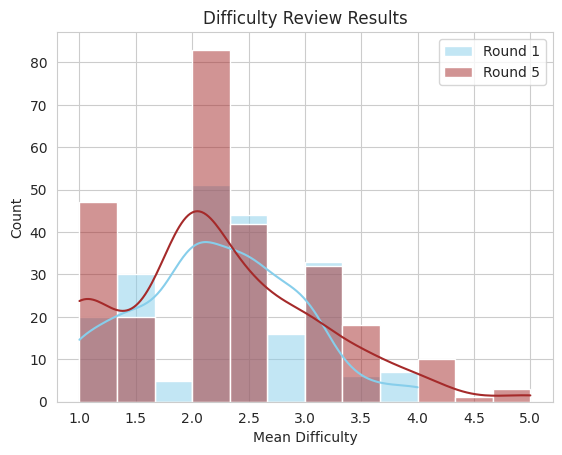

In [74]:
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# melted_complexity = pd.melt(ratings_round_4[["Complexity_rater5","Complexity_rater1","Complexity_rater4","Complexity_rater2", "RoundOfGeneration"]], value_vars=["RoundOfGeneration"], var_name="Round")
melted_complexity = ratings_round_4[["Difficulty_rater5","Difficulty_rater1","Difficulty_rater4","Difficulty_rater2", "RoundOfGeneration"]]
melted_complexity["mean_complexity"] = melted_complexity[["Difficulty_rater5","Difficulty_rater1","Difficulty_rater4","Difficulty_rater2"]].mean(axis=1,numeric_only=True)
# sns.distplot(ratings_round_1_complexity, label="Complexity - Round 1",kde=False,)
# sns.distplot(ratings_round_4_complexity, label="Complexity - Round 5",kde=False,)
sns.histplot(data=melted_complexity[melted_complexity["RoundOfGeneration"] == 1], x="mean_complexity", color="skyblue", label="Round 1",kde=True)
sns.histplot(data=melted_complexity[melted_complexity["RoundOfGeneration"] == 5], x="mean_complexity", color="brown", label="Round 5",kde=True)
plt.xlabel("Mean Difficulty")
plt.title("Difficulty Review Results")
plt.legend()
plt.savefig("difficulty_ratings.svg",dpi=300)